# Lecture 2 - Neural network deep dive

> A deep dive into optimising neural networks with stochastic gradient descent

## Learning objectives

* Understand what stochastic gradient descent is and how to minimise functions with it in PyTorch
* Understand all the ingredients needed to define a `Learner` in fastai

## References

* This lecture draws heavily from Chapter 4 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger. The main difference is the use of a tabular jet tagging dataset instead of MNIST to showcase how all the elements of a `Learner` are combined.

## Imports

In [1]:
import torch
from datasets import load_dataset
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split

In [2]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Stochastic gradient descent

What does it actually mean to _train_ a model? In deep learning, this process is called _stochastic gradient descent_ (SGD) and involves 7 main steps:

1. Initialize the parameters of the neural network
2. For each example in the dataset, use the parameters to make a predicition (e.g. is this jet produced by a top-quark or QCD background?)
3. Use these predictions to calculate the model performance via the _loss_
4. Calculate the _gradients_
5. Update all the parameters by taking a _step_ in the direction that minimises the loss
6. Repeat from step 2
7. Stop the training process once the model is good enough

In this lecture, we will take a deep dive into how these steps work in PyTorch. But before doing that, let's take a quick look at how gradients are computed in PyTorch, as they'll play a large role in what follows.

### Calculating gradients

To illustrate how gradients are computed in PyTorch, let's consider a simple quadratic loss function:

In [3]:
def f(x):
    return x**2

Next, let's create a tensor at the point we wish to calculate the gradient of $f(x)$:

In [4]:
xt = tensor(3.0).requires_grad_()
xt

tensor(3., requires_grad=True)

Here, the special `requires_grad_()` method tells PyTorch to begin recording operations on the tensor `xt`; in particular which parts of the code should be included for computing gradients. Next, let's use this tensor to generate the output `yt` from our function:

In [5]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

This looks good and here PyTorch is indicating both the value of the tensor and the gradient function that will be used. So let's now compute the gradients with the `backward()` method:

In [6]:
yt.backward()

Here, "backward" refers to _backpropagation_, which is the technique used in deep learning to compute the gradients of the loss with respect to all the weights in the model. We'll look at backpropagation in a bit more detail soon, but for now the main thing to note is that the gradients are stored in the `Tensor.grad` attribute:

In [7]:
xt.grad

tensor(6.)

Great, this worked since we know analytically that $f'(3) = 6$! Now let's generalise to the case where our tensor is an array of values:

In [8]:
xt = tensor([3.0, 4.0, 10.0]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

To compute the gradients, we'll also need to add a `sum()` operator to our function so that it returns a scalar:

In [9]:
def f(x):
    return (x**2).sum()


yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Here we can see that passing an array of values and applying the sum is equivalent to computing:

$$ f(x_0) = \sum_i x_i^2 \Big|_{x_0}  $$ 

Finally, let's check the values of our gradients $f'(x_0)$:

In [10]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Now that we know how to compute gradients, we next need to find a way to update all the weights. Let's take a look at this with a more realistic example.

## An end-to-end example

Imagine that you're measuring some signal at fixed time steps:

In [11]:
time = torch.arange(0, 20).float()

and then find the result of your measurements looks something like a parabola:

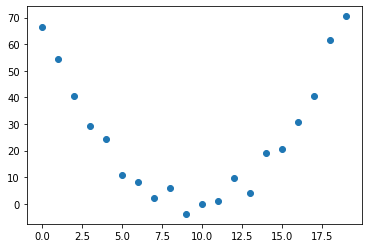

In [12]:
signal = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, signal);

Using SGD, our goal will be to find a function that best fits the data. A good choice of function would be a general quadratic of the form:

$$ f(t) = at^2 + bt + c $$

We can then define a function that collects the timestep $t$ and the parameters $a,b,c$ as separate arguments:

In [13]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

To define what we mean by "best" values of $a,b,c$, we'll need to choose a loss function. For regression problems like ours, it is common to use the mean squared error, which we can define as follows:

In [14]:
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

Now that we have a function we with to optimise and a loss function, let's work through the 7 steps of training a model.

### Step 1: Initialize the parameters

Since our function involves three parameters $a,b,c$, we'll initialise random values of them using the `torch.randn()` function:

In [15]:
set_seed(666)
params = torch.randn(3).requires_grad_()
params

tensor([-2.1188,  0.0635, -1.4555], requires_grad=True)

As we did earlier, we've applied the `requires_grad_()` method to indicate that we wish to track the gradients of the `params` tensor. We've also set the seed to the number of the beast so that the results are reproducible when you run the code on your own machine 😈.

### Step 2: Calculate the predictions

The next step is compute the predictions from the "model":

In [16]:
preds = f(time, params)
preds.shape

torch.Size([20])

Notice that we get one prediction for each of the time step in the `time` array. We can visualise these predictions with the following helper function:

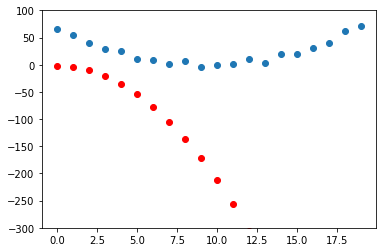

In [17]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, signal)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300, 100)


show_preds(preds)

Unsuprisngly, our randomly initialised model isn't very good - let's see if we can improve it by adjusting the parameters!

### Step 3: Calculate the loss

To know how we should adjust the parameters, we need a way to indicate in which direction we should optimise them. To do so, we'll first compute the loss:

In [18]:
loss = mse(preds, signal)
loss

tensor(144123.2188, grad_fn=<MeanBackward0>)

To improve this value (i.e. make it lower), we'll need the gradients.

### Step 4: Calculate the gradients

Next we calculate the gradients:

In [19]:
loss.backward()
params.grad

tensor([-127067.0156,   -8144.7261,    -574.7094])

### Step 5: Step the weights

Next we need to update the parameters according to a learning rate. For now we'll just ues $10^{-5}$:

In [20]:
lr = 1e-5
params.data -= lr * params.data
params.grad = None

Let's check if the loss has improved:

In [21]:
preds = f(time, params)
mse(preds, signal)

tensor(144120.5156, grad_fn=<MeanBackward0>)

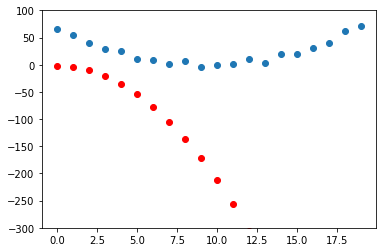

In [22]:
show_preds(preds)

Okay, not much of a change after one step so let's repeat the process a few times to see how things improve. To do so, we'll create another helper function that combines all of the above logic:

In [23]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, signal)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

### Step 6: Repeat the process

Now that we've done one step of gradient descent, it's time to repeat a few times to see if the loss decreases:

In [24]:
for _ in range(10):
    apply_step(params)

144120.515625
27796.125
5783.99853515625
1618.6278076171875
830.4098510742188
681.2518310546875
653.0234985351562
647.678955078125
646.66455078125
646.4696044921875


Great, this seems to work! The loss is decreasing with each step, indicating that a different quadratic function is being tried with different values of the parameters $a,b,c$. We can visualise this process by plotting the intermediate results of the first few steps:

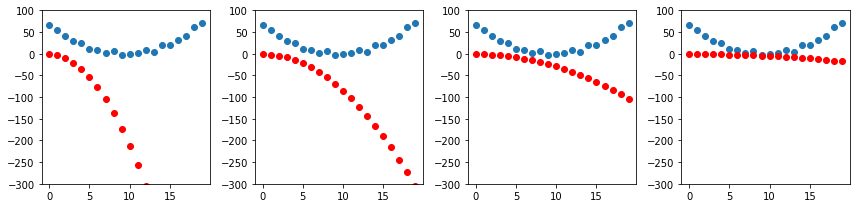

In [25]:
set_seed(666)
params = torch.randn(3).requires_grad_()

_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs:
    show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop

Here we stopped the process after 10 steps, but in practice one would track metrics like accuracy and loss on the validation set to decide when is a good point to terminate the training.

All of these steps can be carried over to any deep learning problem, so let's revisit the $N$-subjettiness dataset of particle jets from lecture 1.

## A real-world example

So far we've focused on optimising simple quadratic functions, but let's now tackle a real-world problem using neural networks! We'll use the same dataset from lecture 1 that contains jets of top-quarks and QCD background. As usual, we'll load the dataset from the Hugging Face Hub and convert it to a Pandas `DataFrame` via the `to_pandas()` method:

In [26]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")
df = nsubjet_ds["train"].to_pandas()
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


### Preparing the data

In lecture 1, we used the `TabularDataLoaders.from_df()` method to quickly create dataloaders for the train and validation sets. In this lecture, we'll take a different approach. We'll first create tensors of the features and labels, wrap them as a PyTorch `Dataset`, and finally create the dataloaders using the generic `DataLoaders` class from fastai.

To get started, we'll need to split our data into a training and validation sets. We can do this quickly via the `train_test_split()` function from scikit-learn:

In [27]:
train_df, valid_df = train_test_split(df, random_state=42)
train_df.shape, valid_df.shape

((908250, 21), (302750, 21))

This has allocated 75% of our original dataset to `train_df` and the remainder to `valid_df`. Now that we have these `DataFrames`, the next thing we'll need are tensors for the features $(p_T, m, \tau_1^{(0.5)},\ldots)$ and labels. PyTorch provides a handy `from_numpy()` method that allows us to quickly convert the values of a `DataFrame` to tensors:

In [442]:
# Slice out all feature columns and cast to float32
train_x = torch.from_numpy(train_df.iloc[:, :-1].values).float()
# Slice out the label column and convert to matrix of shape (num_examples, 1)
train_y = torch.from_numpy(train_df.iloc[:, -1].values).unsqueeze(1)
# Sanity check on the shapes
train_x.shape, train_y.shape

(torch.Size([908250, 20]), torch.Size([908250, 1]))

From these tensors we can now create a PyTorch `Dataset`. These objects need to return a tuple of $(x,y)$ pairs when indexed, and we can achieve this by simply combining a Python `list` with the `zip` function:

In [443]:
train_dset = list(zip(train_x, train_y))
x, y = train_dset[0]
x.shape, y

(torch.Size([20]), tensor([1]))

This look good for a single example in the dataset, so let's also do the same steps for the validation set:

In [444]:
valid_x = torch.from_numpy(valid_df.iloc[:, :-1].values).float()
valid_y = torch.from_numpy(valid_df.iloc[:, -1].values).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [481]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# train_x, valid_x = torch.from_numpy(scaler.fit_transform(train_x)).float(), torch.from_numpy(scaler.fit_transform(valid_x)).float()

### Initialise the parameters

Next we need to a way to randomly initialize the parameters of the models we'll create. To do so, we can create a simple helper function:

In [446]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


set_seed(666)
weights = init_params((20, 1))

Recall that in neural networks, a linear transformation is applied to each input `x`, so we'll also need to initialize the bias term:

In [447]:
set_seed(666)
bias = init_params(1)

With these parameters, we can create a simple linear classifier that predicts the jet class for a single example:

In [448]:
(x * weights.T).sum() + bias

tensor([-293.2585], grad_fn=<AddBackward0>)

Now in principle, we'd like to compute the predictions of _all_ the examples in our training set. We could do this with a Python for-loop, but this will be extremely slow and won't make use of the acceleration provided by a GPU. Instead, we'll use matrix multiplication to compute all the predictions in one go:

In [449]:
def linear_model(xb):
    return xb @ weights + bias

With this simple linear classifier, we can now compute the predictions over the whole training set:

In [450]:
preds = linear_model(train_x)
preds

tensor([[-1.0355],
        [-5.4567],
        [-0.9416],
        ...,
        [-1.4827],
        [-4.6571],
        [-7.6550]], grad_fn=<AddBackward0>)

Now that we have a model we can generate predictions from (step 2), the next thing we need is a loss function to measure how well these predictions compare to the true values.

## Binary cross entropy

Suppose 

In [518]:
def binary_cross_entropy(predictions, targets):
    predictions = predictions.sigmoid()
    print(predictions)
    return -torch.where(targets == 1, predictions, 1 - predictions).log().mean()

### SGD and mini-batches

In [501]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([11,  9,  1,  3,  0]),
 tensor([13, 10,  6,  5,  7]),
 tensor([ 2,  4,  8, 12, 14])]

In [502]:
weights = init_params((20, 1))
bias = init_params(1)

In [503]:
train_dl = DataLoader(train_dset, batch_size=1024, shuffle=True)

In [504]:
xb,yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([1024, 20]), torch.Size([1024, 1]))

In [505]:
valid_dl = DataLoader(valid_dset, batch_size=1024)

In [506]:
preds = linear_model(xb)

In [516]:
preds[:10]

tensor([[408.8538],
        [173.9517],
        [366.2723],
        [181.1378],
        [297.0280],
        [155.0407],
        [148.4101],
        [290.3214],
        [110.0510],
        [242.1872]], grad_fn=<SliceBackward0>)

In [519]:
loss = binary_cross_entropy(preds[:10], yb[:10])
loss

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


tensor(inf, grad_fn=<NegBackward0>)

In [523]:
loss = nn.BCELoss()
loss(preds[:10], yb[:10])

RuntimeError: Found dtype Long but expected Float

In [520]:
F.binary_cross_entropy_with_logits(preds, yb)

RuntimeError: result type Float can't be cast to the desired output type Long

In [306]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([20]), tensor(0.), tensor([0.]))

In [307]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = binary_cross_entropy(preds, yb)
    loss.backward()

In [309]:
weights.grad.mean(), bias.grad

(tensor(0.), tensor([0.]))

In [337]:
simple_net = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)

In [338]:
dls = DataLoaders(train_dl, valid_dl)

In [339]:
batch = first(dls.train)

In [340]:
batch[0].shape

torch.Size([1024, 20])

In [341]:
batch[1].shape

torch.Size([1024])

In [342]:
simple_net(batch[0]).shape

torch.Size([1024, 2])

In [343]:
binary_cross_entropy(simple_net(batch[0]), batch[1])

RuntimeError: The size of tensor a (1024) must match the size of tensor b (2) at non-singleton dimension 1

In [344]:
F.cross_entropy(simple_net(batch[0]), batch[1])

tensor(0.8711, grad_fn=<NllLossBackward0>)

In [348]:
learn = Learner(
    dls,
    simple_net,
    opt_func=SGD,
    loss_func=nn.CrossEntropyLoss(),
    metrics=[accuracy, RocAucBinary()],
)

In [349]:
learn.summary()

Sequential (Input shape: 1024 x 20)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 200          
Linear                                    4200       True      
ReLU                                                           
Linear                                    40200      True      
ReLU                                                           
____________________________________________________________________________
                     1024 x 50           
Linear                                    10050      True      
ReLU                                                           
Linear                                    2550       True      
ReLU                                                           
____________________________________________________________________________
                     1024 x 2            
Linear                                    102        True      
____________________________________________

SuggestedLRs(valley=4.365158383734524e-05)

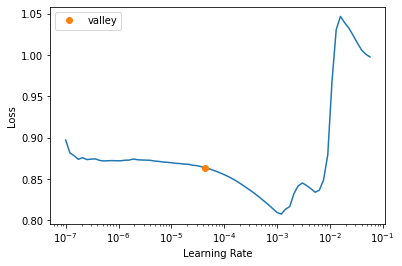

In [350]:
learn.lr_find()

In [351]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.313139,0.320223,0.874471,0.912726,00:05
1,0.305614,0.303472,0.880766,0.925295,00:05
2,0.302619,0.302697,0.880968,0.926046,00:05
